# Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

#Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

#Data fetch

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)


Found 3864 files belonging to 11 classes.
Using 3478 files for training.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 435 files belonging to 11 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

#Build model

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Callback and data augmentation objects:

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='checkpoint_resnet101.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

##### ResNet101 class:

In [ ]:
class ResNet101:
    LOSS = 'categorical_crossentropy'

    def __init__(self, train=None, test=None, val=None, classes=11, epochs=10,
                 callbacks_list=None, data_augmentation=None, class_weights=None):
        # set datasets
        self.training_set = train
        self.test_set = test
        self.val_set = val

        # model
        self.model = None

        # utils
        self.history = None
        self.classes = classes
        self.epochs = epochs
        self.callbacks_list = callbacks_list
        self.data_augmentation = data_augmentation
        self.class_weights = class_weights

    """
        ARCHITECTURE TO TEST
    """

    def classic_resnet101(self):
        inputs = self.input()
        x = self.base_resnet101v2()(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet101_finetuned(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet101_finetuned_drop(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet101_finetuned_dense(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense1')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense2')(x)
        #x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    """
            NETWORK PIECE BY PIECE STRUCTURE BLOCK
    """

    def input(self):
        inputs = ks.Input(shape=(224, 224, 3))
        x = ks.applications.resnet50.preprocess_input(inputs)
        x = self.data_augmentation(x)
        x = layers.Rescaling(1. / 255)(x)
        return x

    def base_resnet101v2(self):
        res = ResNet101V2(
            weights=None,
            include_top=False,
            input_shape=((224, 224, 3))
        )
        res.trainable = False
        return res

    def fine_tuning(self, num_of_blocks=1):
        if num_of_blocks < 1:
            num_of_blocks = 1

        res = self.base_resnet101v2()
        res.trainable = True
        set_trainable = False

        if num_of_blocks == 1:
            block_name = 'conv5_block2_out'
        elif num_of_blocks == 2:
            block_name = 'conv4_block23_out'
        elif num_of_blocks == 3:
            block_name = 'conv4_block13_out'
        elif num_of_blocks == 4:
            block_name = 'conv4_block10_out'


        for layer in res.layers:
            if layer.name == block_name:
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        return res

    """
            UTILITIES
    """

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, model_name, show_shapes=True)

    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
        plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.plot()

    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
        plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.plot()

    def summary(self):
        self.model.summary()

    """
          COMPILE AND FIT
    """

    def compile_and_fit(self, optimizer):
        self.model.compile(
            optimizer=optimizer,
            loss=self.LOSS,
            metrics=['accuracy']
        )

        if self.callbacks_list is None:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set
            )
        else:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set,
                callbacks=self.callbacks_list,
                class_weight=self.class_weights
            )

    def evaluate(self):
        test_loss, test_acc = self.model.evaluate(self.test_set)
        print(f"Test accuracy: {test_acc:.3f}")

#### Feature extraction:

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.classic_resnet101()
resnet101.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 22,539
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 14.6604 - accuracy: 0.1277

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 72s 2s/step - loss: 14.6604 - accuracy: 0.1277 - val_loss: 5.8898 - val_accuracy: 0.1088
Epoch 2/60
28/28 [==============================] - 48s 1s/step - loss: 4.0915 - accuracy: 0.1952 - val_loss: 2.6595 - val_accuracy: 0.2617
Epoch 3/60
28/28 [==============================] - 49s 1s/step - loss: 2.4222 - accuracy: 0.2769 - val_loss: 2.0112 - val_accuracy: 0.2850
Epoch 4/60
28/28 [==============================] - 47s 1s/step - loss: 2.3354 - accuracy: 0.3022 - val_loss: 2.1552 - val_accuracy: 0.3057
Epoch 5/60
28/28 [==============================] - 48s 1s/step - loss: 2.2258 - accuracy: 0.3295 - val_loss: 1.9877 - val_accuracy: 0.3420
Epoch 6/60
28/28 [==============================] - 48s 1s/step - loss: 2.2325 - accuracy: 0.3407 - val_loss: 1.9798 - val_accuracy: 0.3756
Epoch 7/60
28/28 [==============================] - 47s 1s/step - loss: 2.1556 - accuracy: 0.3562 - val_loss: 2.3893 - val_accuracy: 0.3031
Epoch 8/60
28/28 [============

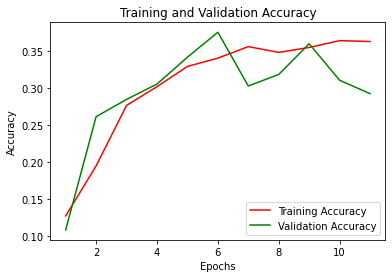

In [ ]:
resnet101.plot_accuracy()

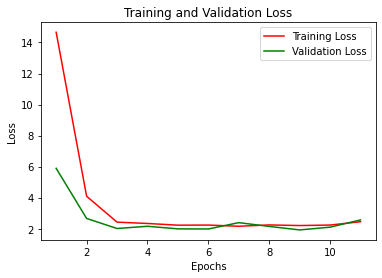

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 12s 2s/step - loss: 2.6044 - accuracy: 0.3195
Test accuracy: 0.320


## Fine tuning one block

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned(num_of_blocks=1)
resnet101.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 4,491,275
Non-trainable params: 38,157,824
_________________________________________________________________


In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 63s 2s/step - loss: 2.1377 - accuracy: 0.3249 - val_loss: 50.8077 - val_accuracy: 0.0803
Epoch 2/60
28/28 [==============================] - 49s 2s/step - loss: 1.8328 - accuracy: 0.4393 - val_loss: 29.6608 - val_accuracy: 0.0674
Epoch 3/60
28/28 [==============================] - 49s 2s/step - loss: 1.6468 - accuracy: 0.4819 - val_loss: 10.2051 - val_accuracy: 0.1399
Epoch 4/60
28/28 [==============================] - 49s 2s/step - loss: 1.5507 - accuracy: 0.5354 - val_loss: 5.9820 - val_accuracy: 0.2021
Epoch 5/60
28/28 [==============================] - 49s 2s/step - loss: 1.5412 - accuracy: 0.5201 - val_loss: 3.5348 - val_accuracy: 0.3472
Epoch 6/60
28/28 [==============================] - 49s 2s/step - loss: 1.4017 - accuracy: 0.5727 - val_loss: 3.3867 - val_accuracy: 0.3368
Epoch 7/60
28/28 [==============================] - 49s 2s/step - loss: 1.3950 - accuracy: 0.5664 - val_loss: 3.1582 - val_accuracy: 0.3601
Epoch 8/60
28/28 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 50s 2s/step - loss: 1.2960 - accuracy: 0.6072 - val_loss: 1.8315 - val_accuracy: 0.4249
Epoch 9/60
28/28 [==============================] - 50s 2s/step - loss: 1.2472 - accuracy: 0.6141 - val_loss: 1.7163 - val_accuracy: 0.4689
Epoch 10/60
28/28 [==============================] - 50s 2s/step - loss: 1.1525 - accuracy: 0.6495 - val_loss: 1.5292 - val_accuracy: 0.5337
Epoch 11/60
28/28 [==============================] - 49s 2s/step - loss: 1.0522 - accuracy: 0.6786 - val_loss: 2.9798 - val_accuracy: 0.4171
Epoch 12/60
28/28 [==============================] - 49s 2s/step - loss: 1.0307 - accuracy: 0.6794 - val_loss: 2.0289 - val_accuracy: 0.4560
Epoch 13/60
28/28 [==============================] - 49s 2s/step - loss: 0.9641 - accuracy: 0.7007 - val_loss: 1.7628 - val_accuracy: 0.5492
Epoch 14/60
28/28 [==============================] - 49s 2s/step - loss: 0.8845 - accuracy: 0.7294 - val_loss: 2.4991 - val_accuracy: 0.4352
Epoch 15/60
28/28 [=======

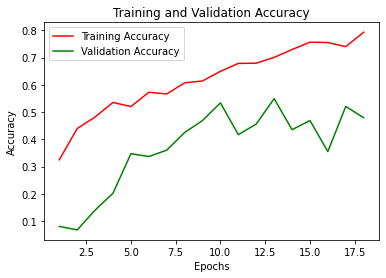

In [ ]:
resnet101.plot_accuracy()

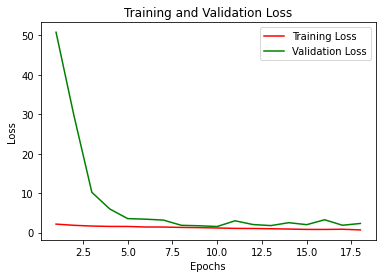

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 7s 1s/step - loss: 2.3036 - accuracy: 0.5218
Test accuracy: 0.522


### Finetuned heavy block 5 entirely

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned(num_of_blocks=2)
resnet101.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 14,993,419
Non-trainable params: 27,655,680
_________________________________________________________________


In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 2.2811 - accuracy: 0.3700

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 85s 2s/step - loss: 2.2811 - accuracy: 0.3700 - val_loss: 52.8859 - val_accuracy: 0.1140
Epoch 2/60
28/28 [==============================] - 56s 2s/step - loss: 1.6561 - accuracy: 0.5066 - val_loss: 15.8619 - val_accuracy: 0.1321
Epoch 3/60
28/28 [==============================] - 56s 2s/step - loss: 1.5108 - accuracy: 0.5489 - val_loss: 7.0158 - val_accuracy: 0.2047
Epoch 4/60
28/28 [==============================] - 56s 2s/step - loss: 1.3920 - accuracy: 0.5773 - val_loss: 6.3726 - val_accuracy: 0.1736
Epoch 5/60
28/28 [==============================] - 56s 2s/step - loss: 1.2197 - accuracy: 0.6371 - val_loss: 2.0292 - val_accuracy: 0.4560
Epoch 6/60
28/28 [==============================] - 54s 2s/step - loss: 1.1029 - accuracy: 0.6656 - val_loss: 3.6047 - val_accuracy: 0.3316
Epoch 7/60
28/28 [==============================] - 55s 2s/step - loss: 1.0339 - accuracy: 0.6901 - val_loss: 3.4269 - val_accuracy: 0.3342
Epoch 8/60
28/28 [===========

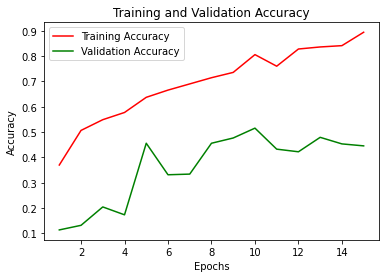

In [ ]:
resnet101.plot_accuracy()

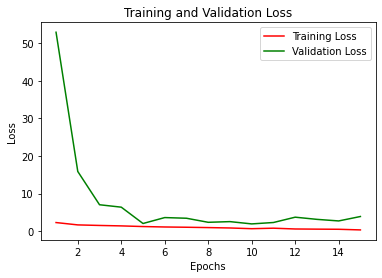

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 11s 2s/step - loss: 3.4421 - accuracy: 0.4805
Test accuracy: 0.480


### Fine tuned heavy half block 4

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned(num_of_blocks=3)
resnet101.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 26,175,499
Non-trainable params: 16,473,600
_________________________________________________________________


In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 93s 3s/step - loss: 2.3505 - accuracy: 0.3746 - val_loss: 448.4590 - val_accuracy: 0.2202
Epoch 2/60
28/28 [==============================] - 75s 2s/step - loss: 1.6095 - accuracy: 0.5104 - val_loss: 32.0145 - val_accuracy: 0.2202
Epoch 3/60
28/28 [==============================] - 75s 2s/step - loss: 1.4425 - accuracy: 0.5538 - val_loss: 12.8392 - val_accuracy: 0.1658
Epoch 4/60
28/28 [==============================] - 75s 2s/step - loss: 1.2704 - accuracy: 0.6245 - val_loss: 6.2217 - val_accuracy: 0.1244
Epoch 5/60
28/28 [==============================] - 75s 2s/step - loss: 1.1928 - accuracy: 0.6417 - val_loss: 2.0930 - val_accuracy: 0.3834
Epoch 6/60
28/28 [==============================] - 75s 2s/step - loss: 0.9666 - accuracy: 0.7030 - val_loss: 1.9884 - val_accuracy: 0.4223
Epoch 7/60
28/28 [==============================] - 75s 2s/step - loss: 0.7691 - accuracy: 0.7677 - val_loss: 2.4941 - val_accuracy: 0.4508
Epoch 8/60
28/28

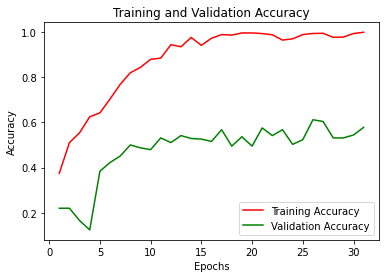

In [ ]:
resnet101.plot_accuracy()

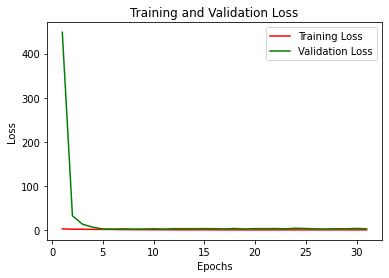

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 8s 1s/step - loss: 2.3642 - accuracy: 0.5977
Test accuracy: 0.598


### Finetune half block 4 + dropout

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned_drop(num_of_blocks=3)
resnet101.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 26,175,499
Non-trainable params: 16,473,600
______________________________________

In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 92s 3s/step - loss: 2.4131 - accuracy: 0.3404 - val_loss: 651.0247 - val_accuracy: 0.0699
Epoch 2/60
28/28 [==============================] - 75s 2s/step - loss: 1.8889 - accuracy: 0.4385 - val_loss: 62.5725 - val_accuracy: 0.2202
Epoch 3/60
28/28 [==============================] - 75s 2s/step - loss: 1.6278 - accuracy: 0.5069 - val_loss: 16.2632 - val_accuracy: 0.1010
Epoch 4/60
28/28 [==============================] - 75s 2s/step - loss: 1.4532 - accuracy: 0.5710 - val_loss: 3.8401 - val_accuracy: 0.2953
Epoch 5/60
28/28 [==============================] - 75s 2s/step - loss: 1.3355 - accuracy: 0.5986 - val_loss: 2.8450 - val_accuracy: 0.3290
Epoch 6/60
28/28 [==============================] - 75s 2s/step - loss: 1.1161 - accuracy: 0.6567 - val_loss: 3.8764 - val_accuracy: 0.2902
Epoch 7/60
28/28 [==============================] - 75s 2s/step - loss: 0.9306 - accuracy: 0.7056 - val_loss: 2.2677 - val_accuracy: 0.4275
Epoch 8/60
28/28

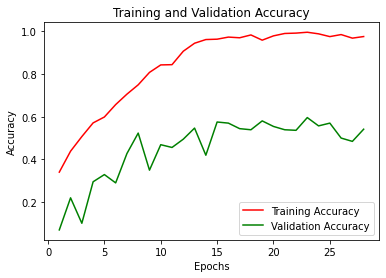

In [ ]:
resnet101.plot_accuracy()

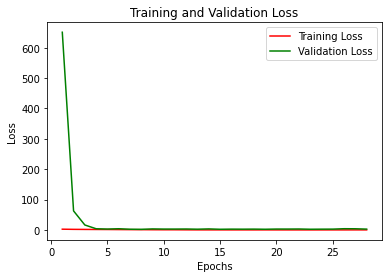

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 7s 1s/step - loss: 2.8590 - accuracy: 0.5356
Test accuracy: 0.536


#### Adding dense layers at the end of the network

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned_dense(num_of_blocks=3)
resnet101.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 my_dense1 (Dense)           (None, 256)               524544    
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 predictions (Dense)         (None, 11)                2827      
                                                           

In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - 87s 3s/step - loss: 2.0845 - accuracy: 0.3577 - val_loss: 6.0919 - val_accuracy: 0.1114
Epoch 2/60
28/28 [==============================] - 75s 2s/step - loss: 1.6055 - accuracy: 0.5187 - val_loss: 4.1233 - val_accuracy: 0.0907
Epoch 3/60
28/28 [==============================] - 75s 2s/step - loss: 1.3356 - accuracy: 0.6081 - val_loss: 2.8070 - val_accuracy: 0.1399
Epoch 4/60
28/28 [==============================] - 76s 2s/step - loss: 1.0312 - accuracy: 0.6993 - val_loss: 2.1656 - val_accuracy: 0.3290
Epoch 5/60
28/28 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.7599

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 77s 3s/step - loss: 0.7732 - accuracy: 0.7599 - val_loss: 1.6329 - val_accuracy: 0.4171
Epoch 6/60
28/28 [==============================] - 75s 2s/step - loss: 0.5408 - accuracy: 0.8367 - val_loss: 1.8718 - val_accuracy: 0.4301
Epoch 7/60
28/28 [==============================] - 75s 2s/step - loss: 0.3300 - accuracy: 0.8971 - val_loss: 2.1234 - val_accuracy: 0.4508
Epoch 8/60
28/28 [==============================] - 75s 2s/step - loss: 0.2172 - accuracy: 0.9370 - val_loss: 2.3371 - val_accuracy: 0.4560
Epoch 9/60
28/28 [==============================] - 75s 2s/step - loss: 0.1375 - accuracy: 0.9600 - val_loss: 1.8431 - val_accuracy: 0.5389
Epoch 10/60
28/28 [==============================] - 75s 2s/step - loss: 0.1879 - accuracy: 0.9505 - val_loss: 2.2280 - val_accuracy: 0.5233
Epoch 11/60
28/28 [==============================] - 75s 2s/step - loss: 0.1164 - accuracy: 0.9626 - val_loss: 1.6339 - val_accuracy: 0.6062
Epoch 12/60
28/28 [==========

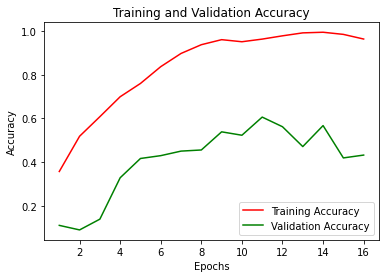

In [ ]:
resnet101.plot_accuracy()

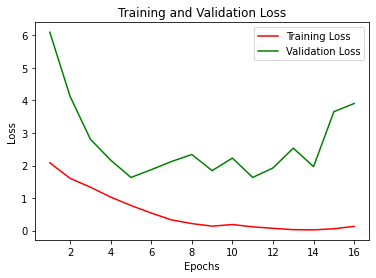

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 9s 1s/step - loss: 3.5964 - accuracy: 0.4552
Test accuracy: 0.455


#### Going Deeper

In [ ]:
resnet101 = ResNet101(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet101.resnet101_finetuned(num_of_blocks=4)
resnet101.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 42,649,099
Trainable params: 29,530,123
Non-trainable params: 13,118,976
_________________________________________________________________


In [ ]:
resnet101.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 93s 3s/step - loss: 2.2356 - accuracy: 0.3784 - val_loss: 20233.9824 - val_accuracy: 0.0596
Epoch 2/60
28/28 [==============================] - 81s 3s/step - loss: 1.6875 - accuracy: 0.4942 - val_loss: 470.6579 - val_accuracy: 0.0596
Epoch 3/60
28/28 [==============================] - 81s 3s/step - loss: 1.4893 - accuracy: 0.5460 - val_loss: 12.5194 - val_accuracy: 0.1839
Epoch 4/60
28/28 [==============================] - 81s 3s/step - loss: 1.3901 - accuracy: 0.5733 - val_loss: 14.5812 - val_accuracy: 0.1399
Epoch 5/60
28/28 [==============================] - 81s 3s/step - loss: 1.2195 - accuracy: 0.6308 - val_loss: 3.7561 - val_accuracy: 0.2876
Epoch 6/60
28/28 [==============================] - 81s 3s/step - loss: 1.0806 - accuracy: 0.6754 - val_loss: 3.4902 - val_accuracy: 0.3212
Epoch 7/60
28/28 [==============================] - 81s 3s/step - loss: 0.8767 - accuracy: 0.7355 - val_loss: 2.7485 - val_accuracy: 0.4301
Epoch 8/60
2

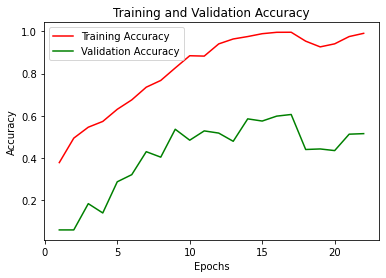

In [ ]:
resnet101.plot_accuracy()

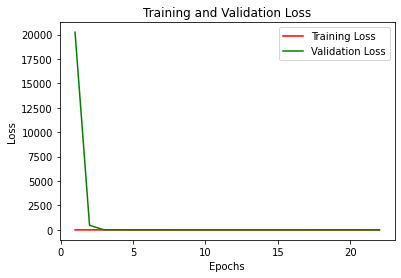

In [ ]:
resnet101.plot_loss()

In [ ]:
resnet101.evaluate()

4/4 [==============================] - 9s 1s/step - loss: 2.5997 - accuracy: 0.5310
Test accuracy: 0.531
